# Convolutional Neural Network and Adversarial Attacks

En el siguiente código se crea una red neuronal convolucional que identifica dígitos escritos a mano para posteriormente engañarla usando un white box adversarial attack conocido como FGSM

# Importaciones y definición de CPU o GPU

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Poner -1 para CPU y comentar para GPU

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
import time

start = time.time() # Creamos un contador para ver el tiempo que tarda la ejecución

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # Imprimimos qué usará como comprobación

Num GPUs Available:  1


# Dataset

A continuación descargamos el dataset

In [2]:
#  Cargamos el dataset y lo dividimos en entrenamiento y entreno
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Reducimos el dataset para hacer que la compilación sea más rápida
NUM_TRAINSET = 60000    # El número máximo es 60000
NUM_TESTSET = 10000     # El número máximo es 10000

train_images, train_labels = train_images[0:NUM_TRAINSET, :, :], train_labels[0:NUM_TRAINSET]
test_images, test_labels = test_images[0:NUM_TESTSET, :, :], test_labels[0:NUM_TESTSET]

# Importante: normalizar los píxeles entre 0 y 1. También se puede usar el método normalize
train_images, test_images = train_images / 255.0, test_images / 255.0

## Comprobamos el formato

Elegimos una imagen y mostramos su imagen y su etiqueta

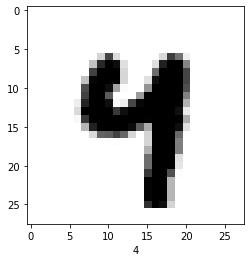

In [3]:
num_imagen = randrange(NUM_TESTSET)

plt.imshow(train_images[num_imagen] ,cmap=plt.cm.binary)
plt.xlabel(train_labels[num_imagen])
plt.show()

## Reshape
La red espera una entrada de la forma (60000, 28, 28, 1), mientras que el dataset se almacena sin indicar explícitamente el 1 de los canales de color, de forma que tenemos que modificar la entrada para incluirlo

In [4]:
train_images = train_images.reshape(NUM_TRAINSET,28,28,1)
test_images = test_images.reshape(NUM_TESTSET,28,28,1)

# Definición de la red

In [5]:
# Creamos un modelo secuencial, es decir, la información fluirá de izquierda a derecha
model = models.Sequential()

# Añadimos las capas convolucionales
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Y posteriormente, las pasamos a capas lineales
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) # Que escojamos 64 neuronas no tiene nada que ver con lo anterior
model.add(layers.Dense(10, activation='softmax'))

# Echemos un vistazo a cómo nos queda la red
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Creación de la red

In [6]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

## Entrenamiento de la red

In [7]:
entrenamiento = model.fit(train_images, train_labels, batch_size = 32, epochs=3, validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.3207 - accuracy: 0.9007 - val_loss: 0.0511 - val_accuracy: 0.9848
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0513 - accuracy: 0.9833 - val_loss: 0.0473 - val_accuracy: 0.9844
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.0277 - val_accuracy: 0.9908
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.0304 - val_accuracy: 0.9899
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0284 - val_accuracy: 0.9922
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.0351 - val_accuracy: 0.9892
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.0313 - val_accuracy:

## Análisis de resultados

Comprobamos ahora en función de los datos de pérdida y precisión si sería beneficial aumentar las épocas o no

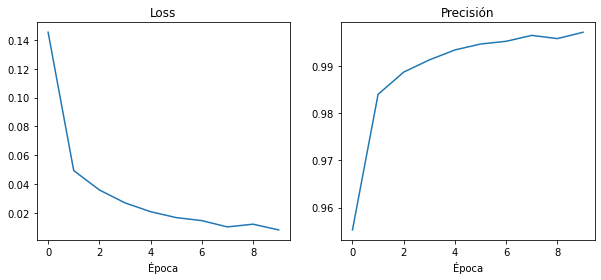

In [8]:
# Mostramos la pérdida y la precisión
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title("Loss")
plt.xlabel("Época")
plt.plot(entrenamiento.history['loss'], label= "Loss")

plt.subplot(122)
plt.title("Precisión")
plt.xlabel("Época")
plt.plot(entrenamiento.history['accuracy'], label= "Precisión")

En base a la gráfica se observa que el valor ideal de épocas es 3 (empezamos en 0)

In [9]:
entrenamiento.history['val_accuracy']

[0.9847999811172485,
 0.9843999743461609,
 0.9908000230789185,
 0.9898999929428101,
 0.9922000169754028,
 0.9891999959945679,
 0.991100013256073,
 0.9904000163078308,
 0.9909999966621399,
 0.9894000291824341]

### Guardar datos en txt

Guardamos los resultados en un txt para poder crear las figuras en latex

In [10]:
# Creamos un vector x con el número de épocas desde 1
x = np.linspace(1, len(entrenamiento.history['loss']), num =len(entrenamiento.history['loss']))
        
# Formamos una matriz y la transponemos para que los vectores se queden como columnas
matriz = np.array([x, entrenamiento.history['loss']])
matriz = matriz.transpose()
        
# Cuardamos el txt definiendo las columnas, el formato, el delimitador y evitando que aparezca el hastagh
np.savetxt("mnistbasic_loss.txt", matriz, header = 'Epoch Loss', fmt='%1.10f', delimiter = ' ', comments='')

# Repetimos para la precisión
matriz = np.array([x, entrenamiento.history['accuracy']])
matriz = matriz.transpose()
np.savetxt("mnist_basic_accuracy.txt", matriz, header = 'Epoch Accuracy', fmt='%1.10f', delimiter = ' ', comments='')

# Repetimos para la validación
matriz = np.array([x, entrenamiento.history['val_accuracy']])
matriz = matriz.transpose()
np.savetxt("mnist_basic_val_accuracy.txt", matriz, header = 'Epoch Val_Accuracy', fmt='%1.10f', delimiter = ' ', comments='')

# Predicción de resultados

Comprobamos que las imágenes introducidas corresponden con los valores predichos


In [ ]:
num_imagen = randrange(NUM_TESTSET)

plt.imshow(test_images[num_imagen], cmap=plt.cm.binary)
plt.xlabel(test_labels[num_imagen])
plt.show()

print("La clase predicha es:", np.argmax(model.predict([test_images])[num_imagen]), "con una confianza del", 
      round(np.max(model.predict([test_images])[num_imagen])*100, 2), "%")

# Creación del dataset FGSM
### Crear las perturbaciones
Primero calculamos las perturbaciones para el dataset escogido, de forma que podemos realizar el FGSM sobre el test para atacar la red o sobre el train para entrenar posteriormente a la red con él

In [ ]:
# Introducimos el dataset del que queremos imágenes adversariales. De momento es test, luego ya en la defensa pondremos train
dataset = "test"
   
perturbaciones_testset = FGSM(dataset, defensa = 0)

### Creación de las adversarial images
Una vez tenemos las perturbaciones del dataset escogido, lo recorremos para los valores de epsilon deseados obteniendo un vector de predicciones

In [ ]:
# Definimos los valores de epsilon para los que queremos crear el dataset
epsilons = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])

# Creamos nuestro vector vacío con las predicciones
predicciones = np.empty([len(epsilons), NUM_TESTSET, 10])

# Creamos nuestro vector vacío que contendrá el testset
adversarial_testset = np.empty([len(epsilons), NUM_TESTSET, 28, 28, 1])
            
# Recorremos los datasets para cada uno de esos valores de epsilon    
for i in range(len(epsilons)):
    # Creamos el adversarial dataset
    adversarial_testset[i] = creacion_adversarial_dataset(epsilons[i], dataset, perturbaciones_testset)   

    # Calculamos las métricas
    predicciones[i] = model.predict([adversarial_testset[i]])

### Comprobación de que se han creado correctamente

In [ ]:
# Mostramos la forma
print("La forma del vector predicciones es:", predicciones.shape)
print("La forma del adversarial testset es:", adversarial_testset.shape)
    
# Imprimimos una imagen aleatoria con un valor de epsilon aleatorio
num_imagen = randrange(NUM_TESTSET)
valor = randrange(len(epsilons))
    
imagen_original = test_images[num_imagen]
perturbacion = perturbaciones_testset[num_imagen] * 0.5 + 0.5
imagen = adversarial_testset[valor][num_imagen]
    
# Llamamos a la funciones de impresión y predicción
impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilons[valor])
prediccion_adversarial(imagen)

# Análisis de métricas

In [ ]:
# Calculamos los resultados. IMPORTANTE: Poner 1 si estamos trabajando con el dataset adversativo ó 0 si no, ya que creará los txt
# con el nombre correspondiente
metricas(predicciones, NUM_TESTSET, adversativo = 0)

# Defensa frente a ataques adversativos
A continuación tenemos que realizar un proceso muy parecido al anterior pero ahora con el trainset, de forma que obtendremos 60000 imágenes adversativas para el valor o valores de epsilon especificados. Esas imágenes las añadiremos al dataset inicial y entrenaremos a nuestra red con los conjuntos originales y los adversativos de forma que la precisión frente a un ataque debería subir

### Creación de las perturbaciones del trainset

In [ ]:
dataset = "train"
   
perturbaciones_trainset = FGSM(dataset, defensa = 0)

### Creación del trainset adversarial

In [ ]:
# Definimos los valores de epsilon para los que queremos crear el dataset
# Tarda un huevo, así que, de momento, preferiblemente sólo 1. Pongo 0.4 porque es el que hace que sea básicamente random
epsilon = np.array([0.05])

# Creamos nuestro vector vacío que contrendrá el dataset
adversarial_trainset = np.empty([len(epsilon), NUM_TRAINSET, 28, 28, 1])
            
# Recorremos los datasets para cada uno de esos valores de epsilon    
for i in range(len(epsilon)):
    # Creamos el adversarial dataset
    adversarial_trainset[i] = creacion_adversarial_dataset(epsilon[i], dataset, perturbaciones_trainset)   

### Comprobación de que se ha creado correctamente

In [ ]:
# Mostramos la forma
print("La forma del adversarial trainset es:", adversarial_trainset.shape)
    
# Imprimimos una imagen aleatoria con un valor de epsilon aleatorio
valor = randrange(len(epsilon))
num_imagen = randrange(NUM_TRAINSET)

imagen_original = train_images[num_imagen]
perturbacion = perturbaciones_trainset[num_imagen]
imagen = adversarial_trainset[0][num_imagen]

# Llamamos a la funciones de impresión y predicción
impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon[valor])

### Creación del nuevo conjunto de entrenamiento y test con las imágenes adversativas
Hasta ahora tenemos nuestro adversarial trainset y el adversarial dataset. Ahora tenemos que definir qué imágenes queremos de dentro de esos conjuntos, así como establecer sus correctas etiquetas para entrenar posteriormente la red

In [ ]:
# Creación del conjunto de entrenamiento
# Lo inicializamos con las imágenes originales
trainset_defensa = train_images
trainset_defensa_labels = train_labels

# Y vamos añadiendo los epsilons establecidos, aunque típicamente será sólo 1
for i in range(len(epsilon)):
    trainset_defensa = np.concatenate((trainset_defensa, adversarial_trainset[i]))
    trainset_defensa_labels = np.concatenate((trainset_defensa_labels, train_labels))

# Imprimimos las formas para comprobar que son las correctas
print(trainset_defensa.shape)
print(trainset_defensa_labels.shape)

In [ ]:
# Creación del conjunto de test. Lo creamos para los mismos epsilons
testset_defensa = test_images
testset_defensa_labels = test_labels

# Encontramos la posición de epsilon en el vector de epsilons
posicion_epsilon = int(np.where(epsilons == epsilon)[0])

# Y vamos añadiendo el testset que corresponde al mismo valor de epsilon que en el caso anterior, que es la posición 6
testset_defensa = np.concatenate((testset_defensa, adversarial_testset[posicion_epsilon]))
testset_defensa_labels = np.concatenate((testset_defensa_labels, test_labels))

# Imprimimos las formas para comprobar que son las correctas
print(testset_defensa.shape)
print(testset_defensa_labels.shape)

### Entrenamiento del modelo con el nuevo dataset adversarial

In [ ]:
# Creamos un modelo secuencial, es decir, la información fluirá de izquierda a derecha
model_defensa = models.Sequential()

# Añadimos las capas convolucionales
model_defensa.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_defensa.add(layers.MaxPooling2D((2, 2)))
model_defensa.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_defensa.add(layers.MaxPooling2D((2, 2)))
model_defensa.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Y posteriormente, las pasamos a capas lineales
model_defensa.add(layers.Flatten())
model_defensa.add(layers.Dense(64, activation='relu')) # Que escojamos 64 neuronas no tiene nada que ver con lo anterior
model_defensa.add(layers.Dense(10, activation='softmax'))

# Echemos un vistazo a cómo nos queda la red
model_defensa.summary()
# Antes de entrenar al modelo, volvemos a compilarlo para asegurarnos de que se reinicia
model_defensa.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Y entrenamos
entrenamiento = model_defensa.fit(trainset_defensa, trainset_defensa_labels, epochs=3, validation_data=(testset_defensa, testset_defensa_labels), batch_size = 32)

### Ataque a la red preparada para la defensa
Nuestra red ya está preparada para la defensa, así que tenemos que volver a atacarla con el conjunto de imágenes adversativas creadas anteriormente para ver cómo se comporta la red ahora

In [ ]:
# Creamos nuestro vector vacío con las predicciones
predicciones = np.empty([len(epsilons), NUM_TESTSET, 10])
            
# Recorremos los datasets para cada uno de esos valores de epsilon    
for i in range(len(epsilons)):

    # Calculamos las métricas
    predicciones[i] = model_defensa.predict([adversarial_testset[i]])

### Análisis de métricas

In [ ]:
# Volvemos a analizar el modelo pero especificamos que estamos con el dataset adversaativo para que cree los txt
metricas(predicciones, NUM_TESTSET, adversativo = 1)

### Guardamos los datos en un txt

In [ ]:
# Creamos un vector x con el número de epocas desde 1
x = np.linspace(1, len(entrenamiento.history['loss']), num =len(entrenamiento.history['loss']))
        
# Formamos una matriz y la transponemos para que los vectores se queden como columnas
matriz = np.array([x, entrenamiento.history['loss']])
matriz = matriz.transpose()
        
# Cuardamos el txt definiendo las columnas, el formato, el delimitador y evitando que aparezca el hastagh
np.savetxt("mnistbasic_loss.txt", matriz, header = 'Epoch Loss', fmt='%1.10f', delimiter = ' ', comments='')

# Repetimos para la precisión
matriz = np.array([x, entrenamiento.history['accuracy']])
matriz = matriz.transpose()
np.savetxt("mnist_basic_accuracy.txt", matriz, header = 'Epoch Accuracy', fmt='%1.10f', delimiter = ' ', comments='')

# Creación nuevas imágenes adversativas
Veamos ahora qué ocurre si volvemos a atacar la red con nuevas imágenes adversativas

In [ ]:
# Introducimos el dataset del que queremos imágenes adversariales. De momento es test, luego ya en la defensa pondremos train
dataset = "test_adversarial"
   
perturbaciones_testset_defensa = FGSM(dataset, defensa = 1)

### Cálculo de las nuevas predicciones del modelo

In [ ]:
# Creamos nuestro vector vacío con las predicciones
predicciones = np.empty([len(epsilons), NUM_TESTSET*2, 10])

# Creamos nuestro vector vacío que contendrá el testset
adversarial_testset_defensa = np.empty([len(epsilons), NUM_TESTSET*2, 28, 28, 1])
            
# Recorremos los datasets para cada uno de esos valores de epsilon    
for i in range(len(epsilons)):
    # Creamos el adversarial dataset
    adversarial_testset_defensa[i] = creacion_adversarial_dataset(epsilons[i], dataset, perturbaciones_testset_defensa)   

    # Calculamos las métricas
    predicciones[i] = model_defensa.predict([adversarial_testset_defensa[i]])

### Comprobación de que se han creado correctamente

In [ ]:
# Mostramos la forma
print("La forma del vector predicciones es:", predicciones.shape)
print("La forma del adversarial testset es:", adversarial_testset_defensa.shape)
    
# Imprimimos una imagen aleatoria con un valor de epsilon aleatorio
num_imagen = randrange(NUM_TESTSET*2)
valor = randrange(len(epsilons))
    
imagen_original = testset_defensa[num_imagen]
perturbacion = perturbaciones_testset_defensa[num_imagen] * 0.5 + 0.5
imagen = adversarial_testset_defensa[valor][num_imagen]
    
# Llamamos a la funciones de impresión y predicción
impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilons[valor])
prediccion_adversarial(imagen)

### Análisis de métricas con el nuevo modelo
Repetimos los pasos anteriores para comprobar si efectivamente hemos mejorado la precisión

In [ ]:
# Volvemos a analizar el modelo pero especificamos que estamos con el dataset adversativo para que cree los txt
metricas(predicciones, NUM_TESTSET*2, adversativo = 2)

# Imprimimos el tiempo de ejecución
end = time.time()
print("Tiempo ejecución: ", end-start)

# Funciones utilizadas

###  Creación de la perturbación

In [ ]:
def FGSM(dataset, defensa):
    
    # Definimos el dataset a utilizar, si el train o el test
    if dataset == "test":
        dataset = test_images
        labels = test_labels
    elif dataset == "test_adversarial":
        dataset = testset_defensa
        labels = testset_defensa_labels
    else:
        dataset = train_images
        labels = train_labels
    
    # Creamos un vector vacío para almacenar las perturbaciones
    perturbaciones = np.empty([len(dataset), 28, 28, 1])
    
    # Recorremos las imágenes del dataset elegido
    for num_imagen in range(len(dataset)):
        # Expandimos la dimensión
        imagen = dataset[num_imagen]
        imagen = np.expand_dims(imagen, axis = 0)
        label = labels[num_imagen]

        # Convertimos a tensor
        imagen = tf.convert_to_tensor(imagen, dtype = tf.float32)

        # Definimos la función de pérdida
        funcion_loss = tf.keras.losses.SparseCategoricalCrossentropy()

        # Creamos la perturbacion
        def crear_perturbacion(imagen, label):
            with tf.GradientTape() as tape:
                tape.watch(imagen)
                if defensa == 0:
                    prediccion = model(imagen)
                else:
                    prediccion = model_defensa(imagen)
                
                loss = funcion_loss(label, prediccion)

            gradiente = tape.gradient(loss, imagen)
            signo_grad = tf.sign(gradiente)
            return signo_grad

        # Llamamos a la función
        perturbaciones[num_imagen] = crear_perturbacion(imagen, label)

    return perturbaciones

### Creación del dataset adversarial

In [ ]:
def creacion_adversarial_dataset(epsilon, dataset, perturbaciones):
    
     # Definimos el dataset a utilizar, si el train o el test
    if dataset == "test":
        dataset = test_images
        labels = test_labels
    elif dataset == "test_adversarial":
        dataset = testset_defensa
        labels = testset_defensa_labels
    else:
        dataset = train_images
        labels = train_labels
    
    # Creamos el adversarial dataset vacío
    adversarial_dataset = np.empty([len(dataset), 28, 28, 1])
    
    # Recorremos el dataset original y le vamos sumando el vector de perturbaciones creado anteriormente
    for num_imagen in range(len(dataset)):
        adversarial_dataset[num_imagen] = dataset[num_imagen] + epsilon * (perturbaciones[num_imagen] * 0.5 + 0.5)
        adversarial_dataset[num_imagen] = tf.clip_by_value(adversarial_dataset[num_imagen], -1, 1)
    
    return adversarial_dataset

### Impresión del dataset adversarial para cada epsilon

In [ ]:
def impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon):
        
    # Imprimimos una imagen con su perturbación y su imagen adversarial resultante
    plt.figure(figsize=(15,4))

    plt.subplot(131)
    plt.title("Imagen original")
    plt.imshow(imagen_original, cmap=plt.cm.binary)

    plt.subplot(132)
    plt.title("Perturbación")
    plt.imshow(perturbacion, cmap=plt.cm.binary)

    plt.subplot(133)
    plt.title("Imagen adversarial epsilon = {}".format(epsilon))
    plt.imshow(imagen, cmap=plt.cm.binary)

### Predicción de una imagen adversarial

In [ ]:
def prediccion_adversarial(imagen):
    # Primero expandimos una dimensión
    imagen = np.expand_dims(imagen, axis = 0)
    
    # Y realizamos la predicción
    print("La predicción es:", np.argmax(model.predict(imagen)), "con una confianza del", 
          round(np.max(model.predict(imagen)),2)*100, "%")

### Análisis de métricas

In [ ]:
def metricas(predicciones, numero_imagenes, adversativo):

    # Creamos los vectores globales
    aciertos_epsilon = np.empty(len(epsilons)) 
    fallos_epsilon = np.empty(len(epsilons))
    precisiones = np.empty(len(epsilons))
    confianzas = np.empty(len(epsilons)) 

    # Recorremos los epsilons
    for i in range(len(epsilons)):
        aciertos = 0
        confianza = 0

        # Recorremos las predicciones
        if adversativo == 0:
            for j in range(numero_imagenes):
                prediccion = np.argmax(predicciones[i][j])
                confianza = confianza + np.max(predicciones[i][j])
                if prediccion == test_labels[j]:
                    aciertos += 1
        else:
            for j in range(numero_imagenes):
                prediccion = np.argmax(predicciones[i][j])
                confianza = confianza + np.max(predicciones[i][j])
                if prediccion == testset_defensa_labels[j]:
                    aciertos += 1
            
        # Calculamos las métricas para cada epsilon
        fallos = numero_imagenes - aciertos
        precision = (aciertos / numero_imagenes) * 100
        confianza = (confianza / numero_imagenes) * 100
        print("Para epsilon = {}: Aciertos = {}, Fallos = {} luego Precisión = {:0.2f} % con una confianza media del {:0.2f} %"
              . format(epsilons[i], aciertos, fallos, precision, confianza))

        # Creamos un vector con todas las métricas para poder realizar gráficas
        aciertos_epsilon[i] = aciertos
        fallos_epsilon[i] = fallos
        precisiones[i] = precision
        confianzas[i] = confianza

    # Creamos gráficas de los resultados
    plt.figure(figsize=(10,4))

    plt.subplot(121)
    plt.title("Precisión")
    plt.xlabel("Epsilon")
    plt.ylabel("Porcentaje")
    plt.plot(epsilons, precisiones)

    plt.subplot(122)
    plt.title("Confianza")
    plt.xlabel("Epsilon")
    plt.ylabel("Porcentaje")
    plt.plot(epsilons, confianzas)
    
    # Guardamos todos los datos en un txt
    if adversativo == 0:
        nombre = "mnist_test_"
    elif adversativo == 1:
        nombre = "mnist_adversarial_"
    else:
        nombre = "mnist_adversarial_2"
                                          
    matriz = np.array([epsilons, precisiones])
    matriz = matriz.transpose()
    np.savetxt(nombre + "accuracy.txt", matriz, header = 'Epsilon Accuracy', fmt='%1.10f', delimiter = ' ', comments='')
                                                             
    matriz = np.array([epsilons, confianzas])
    matriz = matriz.transpose()
    np.savetxt(nombre + "confianza.txt", matriz, header = 'Epsilon Confianza', fmt='%1.10f', delimiter = ' ', comments='')
